# Midge preprocessing

This file preprocesses the raw data from the midges
The most important step is interpolation to a fixed sampling rate, to make it more convenient to load data using the data loaders.

In [1]:
import os
from pathlib import Path

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm

In [12]:
from conflab.constants import (midge_raw_data_path, midge_data_path, 
    annotated_section_start, annotated_section_end, annotated_section_len)

In [5]:
# load all midge data
data = {}
for midge_folder in tqdm(os.listdir(midge_raw_data_path)):
    subpath = os.path.join(midge_raw_data_path, midge_folder)
    midge_data = {}
    has_data = False
    for f in Path(subpath).rglob('*.csv'):
        df = pd.read_csv(str(f))
        
        df['time'] = pd.to_datetime(df['time'])
        df = df[(df['time'] > annotated_section_start) & (df['time'] <= (annotated_section_end+timedelta(seconds=10)))].reset_index()

        if len(df) == 0:
            print(f'empty dataframe {str(f)} between [{str(annotated_section_start)}, {str(annotated_section_end)}]')
            continue
        
        # convert datetime to seconds
        df['time'] = (df['time'] - df['time'][0]).dt.total_seconds()

        if 'proximity.csv' in str(f):
            k = 'prox'
        elif 'accel.csv' in str(f):
            k = 'accel'
        elif 'gyr.csv' in str(f):
            k = 'gyr'
        elif 'mag.csv' in str(f):
            k = 'mag'
        elif 'rotation.csv' in str(f):
            k = 'rot'
        else:
            pass
        midge_data[k] = df
        has_data = True

    if has_data:
        data[int(midge_folder)] = midge_data

  0%|          | 0/49 [00:00<?, ?it/s]

empty dataframe /mnt/e/data/conflab/release/sensors/raw/39/39_1571927258/1571927259_accel.csv between [2019-10-24 17:03:36.967634, 2019-10-24 17:19:13.967634]
empty dataframe /mnt/e/data/conflab/release/sensors/raw/39/39_1571927258/1571927259_gyr.csv between [2019-10-24 17:03:36.967634, 2019-10-24 17:19:13.967634]
empty dataframe /mnt/e/data/conflab/release/sensors/raw/39/39_1571927258/1571927259_mag.csv between [2019-10-24 17:03:36.967634, 2019-10-24 17:19:13.967634]
empty dataframe /mnt/e/data/conflab/release/sensors/raw/39/39_1571927258/1571927259_proximity.csv between [2019-10-24 17:03:36.967634, 2019-10-24 17:19:13.967634]
empty dataframe /mnt/e/data/conflab/release/sensors/raw/39/39_1571927258/1571927259_rotation.csv between [2019-10-24 17:03:36.967634, 2019-10-24 17:19:13.967634]


In [6]:
def interpolate(df: pd.DataFrame, columns, end_time=None, sr=50):
    x = df['time'].to_numpy()
    y = df[columns].to_numpy()

    fn = interp1d(x, y, axis=0, kind='linear')

    if end_time is None:
        end_time = x[-1]
    xnew = np.arange(x[0], end_time, 1/sr)

    return pd.DataFrame(fn(xnew), columns=columns)

## Plot interpolated sample

In [7]:
sample = data[1]['accel'].copy()
interpolated = interpolate(sample, ['time', 'X', 'Y', 'Z'])

In [8]:
sample.head(5)

,index,Unnamed: 0,time,X,Y,Z
0,125725,125725,0.000,0.097168,-0.936035,0.341797
1,125726,125726,0.019,0.096680,-0.943359,0.360840
2,125727,125727,0.038,0.088379,-0.939941,0.350098
3,125728,125728,0.057,0.087891,-0.945801,0.347168
4,125729,125729,0.076,0.084961,-0.948730,0.344238


In [9]:
interpolated.head(5)

,time,X,Y,Z
0,0.00,0.097168,-0.936035,0.341797
1,0.02,0.096243,-0.943179,0.360274
2,0.04,0.088328,-0.940558,0.349789
3,0.06,0.087428,-0.946263,0.346705
4,0.08,0.086225,-0.955509,0.343894


<AxesSubplot:xlabel='time'>

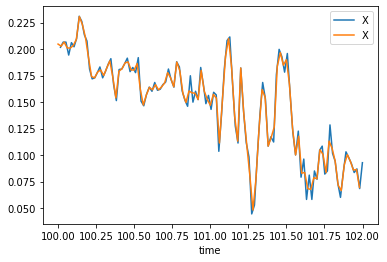

In [10]:
ax = sample[(sample['time'] >= 100) & (sample['time'] < 102)].plot(x='time', y='X')
interpolated[(interpolated['time'] >= 100) & (interpolated['time'] < 102)].plot(x='time', y='X', ax=ax)

# Interpolate and save

In [14]:
for pid, person_data in tqdm(data.items()):

    end_time = annotated_section_len.total_seconds() #person_data['accel']['time'].iloc[-1]

    accel = interpolate(person_data['accel'], ['time', 'X', 'Y', 'Z'], end_time)
    gyr = interpolate(person_data['gyr'], ['time', 'X', 'Y', 'Z'], end_time)
    mag = interpolate(person_data['mag'], ['time', 'X', 'Y', 'Z'], end_time)
    rot = interpolate(person_data['rot'], ['time', 'a', 'b', 'c', 'd'], end_time)
    prox = interpolate(person_data['prox'], ['time', 'rssi'], end_time)

    joint = pd.concat([accel.iloc[:, :], gyr.iloc[:, 1:], mag.iloc[:, 1:], rot.iloc[:, 1:], prox.iloc[:, 1:]], axis=1)
    joint.columns=[
        'time',
        'accelX', 'accelY', 'accelZ',
        'gyrX', 'gyrY', 'gyrZ',
        'magX', 'magY', 'magZ',
        'rotA', 'rotB', 'rotC', 'rotD',
        'rssi'
    ]
    joint.to_csv(os.path.join(midge_data_path, f'{pid}.csv'), index=False)

  0%|          | 0/48 [00:00<?, ?it/s]